# Pancreatitis scRNA-seq Data - Reananalysis

# 1. Download and Initial Processing for Doublet Filtering

The data analysed in this notebook is from Poggetto E; Ho I et al Science 2025 (PMID:34529467). Data can be found on GEO under accession number GSM5494073. ScRNA-seq data are stored in the series GSE181276. The link below can be found by going to https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE181276 and with right click copy the "http" hyperlink in the Download column. 

The flags are required to download this file otherwise it downloads only a HTML page: <br>
-L --> redirects it to the actual file (*_genes.counts_*.txt.gz), without it would only download a HTML page. <br>
-O --> tells curl that it saves the file using the URL filename (without it would be in printed in the terminal) <br>
-J --> tells curl to use the name instead of the final url segment

In [1]:
#Create new direcotry for rawdata
!mkdir -p rawdata
# Download data using curl
!cd rawdata && curl -L -O -J "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE181276&format=file&file=GSE181276_genes.counts_for_GEO_uploading.txt.gz"
# Unzip the gene_counts file in the rawdata folder
!cd rawdata && gunzip "GSE181276_genes.counts_for_GEO_uploading.txt.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  105M  100  105M    0     0  23.7M      0  0:00:04  0:00:04 --:--:-- 25.0M


In [2]:
#Import of software packages
import scanpy as sc
import scvi
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Read file but transpose it as Anndata and Scanpy require cells (barcodes) as rows and gene names in columns (but file has gene names as rows)
adata = sc.read_text('rawdata/GSE181276_genes.counts_for_GEO_uploading.txt').T

In [16]:
# adata.obs contains cell barcodes
adata.obs

""
WT_AAACCCAAGCATCTTG
WT_AAACCCAAGGGTTGCA
WT_AAACCCAGTCCGAAAG
WT_AAACCCAGTCCGTTTC
WT_AAACCCAGTGTGGTCC
...
D7_analysis_TTTGTTGGTGAGCAGT
D7_analysis_TTTGTTGGTGCCTGAC
D7_analysis_TTTGTTGGTTGAGAGC
D7_analysis_TTTGTTGTCCTTATAC


In [17]:
#adata.var contains Gene Names
adata.var

""
Xkr4
Gm1992
Gm37381
Rp1
Sox17
...
AC168977.1
AC149090.1
CAAA01118383.1
Vmn2r122


In [18]:
# Shows size of count matrix (n_cells, n_genes)
adata.shape

(33681, 31053)

In [19]:
Total_gene_number = adata.shape[1]

In [20]:
# Filter to remove genes occuring in less than 10 cells
sc.pp.filter_genes(adata, min_cells=10)

In [21]:
Gene_Number_after_filtering = adata.shape[1]

In [22]:
Loss_of_genes = round((Total_gene_number-Gene_Number_after_filtering)/Total_gene_number*100,2)
Loss_of_genes

43.56

## Doublet Removal

In [23]:
# Subsetting the highly variable genes to train the ScVI model
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor='seurat_v3')

In [24]:
# adata shape after subsetting
adata

AnnData object with n_obs × n_vars = 33681 × 2000
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [25]:
# Train the SCVI Model (required for doublet removal model SOLO)
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/238 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=238` reached.


In [26]:
# Train the doublet class model (it has an stop inside if loss is not changing anymore)
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.208. Signaling Trainer to stop.


In [36]:
# Use predict to annotate the cell barcodes with the trained identifier and annotate it as a string in "doublet" or "singlet"
df = solo.predict()

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


In [38]:
df

,doublet,singlet
WT_AAACCCAAGCATCTTG,0.042626,0.957374
WT_AAACCCAAGGGTTGCA,0.083739,0.916261
WT_AAACCCAGTCCGAAAG,0.100618,0.899382
WT_AAACCCAGTCCGTTTC,0.110715,0.889285
WT_AAACCCAGTGTGGTCC,0.002668,0.997332
...,...,...
D7_analysis_TTTGTTGGTGAGCAGT,0.018691,0.981309
D7_analysis_TTTGTTGGTGCCTGAC,0.348716,0.651284
D7_analysis_TTTGTTGGTTGAGAGC,0.102786,0.897214
D7_analysis_TTTGTTGTCCTTATAC,0.123136,0.876864


In [39]:
df['prediction'] = solo.predict(soft=False)
df

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
WT_AAACCCAAGCATCTTG,0.042626,0.957374,singlet
WT_AAACCCAAGGGTTGCA,0.083739,0.916261,singlet
WT_AAACCCAGTCCGAAAG,0.100618,0.899382,singlet
WT_AAACCCAGTCCGTTTC,0.110715,0.889285,singlet
WT_AAACCCAGTGTGGTCC,0.002668,0.997332,singlet
...,...,...,...
D7_analysis_TTTGTTGGTGAGCAGT,0.018691,0.981309,singlet
D7_analysis_TTTGTTGGTGCCTGAC,0.348716,0.651284,singlet
D7_analysis_TTTGTTGGTTGAGAGC,0.102786,0.897214,singlet
D7_analysis_TTTGTTGTCCTTATAC,0.123136,0.876864,singlet


In [40]:
# Count how many cells are predicted as singlet or doublet
counts = df.groupby('prediction').count()

# Total number of cells
total = counts.sum().values[0]  # or len(df)

# Number of predicted doublets
num_doublets = df.groupby('prediction').count().loc['doublet','doublet']

# Percentage of doublets
percent_doublets = (num_doublets / total) * 100

print(f"Doublets: {num_doublets} / {total} ({percent_doublets:.2f}%)")

Doublets: 4931 / 33681 (14.64%)


In [50]:
df.groupby('prediction').count()

,doublet,singlet,dif
prediction,,,
doublet,4931,4931,4931
singlet,28750,28750,28750


In [57]:
# Generate a list containing only filtered doublet cells (to not loose to much data)
doublets = df[(df['prediction'] == 'doublet')]
doublets

,doublet,singlet,prediction,dif
WT_AAAGAACGTGAGTGAC,0.725324,0.274676,doublet,0.450648
WT_AAAGGATCAACCCTAA,0.934642,0.065358,doublet,0.869284
WT_AAAGGGCCAACCAGAG,0.600469,0.399531,doublet,0.200939
WT_AAAGGGCTCAAATGAG,0.602147,0.397853,doublet,0.204295
WT_AAAGGTAAGACATATG,0.654534,0.345466,doublet,0.309067
...,...,...,...,...
D7_analysis_TTTGACTTCGATTGGT,0.817020,0.182980,doublet,0.634039
D7_analysis_TTTGACTTCTCAGGCG,0.734798,0.265202,doublet,0.469596
D7_analysis_TTTGATCGTAGTGCGA,0.529101,0.470899,doublet,0.058202
D7_analysis_TTTGGTTCACTTCAGA,0.744804,0.255196,doublet,0.489607


We loose 14.64% of cells to doublets. However, since we still have around 29K cells I am here rather strict and do not include a step to select for predictions which are weak in their scores (similar doublet and singlet score). However, I include the script how to filter if it should become necessary later in a sub-chapter.

### 1.1.1 Filtering Doublet Scores to include questionable cells (optional!)

In [52]:
#Calculating the difference of doublet and singlet score to identify cells that have high scores in both (close to 0)
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
WT_AAACCCAAGCATCTTG,0.042626,0.957374,singlet,-0.914749
WT_AAACCCAAGGGTTGCA,0.083739,0.916261,singlet,-0.832521
WT_AAACCCAGTCCGAAAG,0.100618,0.899382,singlet,-0.798764
WT_AAACCCAGTCCGTTTC,0.110715,0.889285,singlet,-0.778571
WT_AAACCCAGTGTGGTCC,0.002668,0.997332,singlet,-0.994664
...,...,...,...,...
D7_analysis_TTTGTTGGTGAGCAGT,0.018691,0.981309,singlet,-0.962618
D7_analysis_TTTGTTGGTGCCTGAC,0.348716,0.651284,singlet,-0.302567
D7_analysis_TTTGTTGGTTGAGAGC,0.102786,0.897214,singlet,-0.794428
D7_analysis_TTTGTTGTCCTTATAC,0.123136,0.876864,singlet,-0.753729


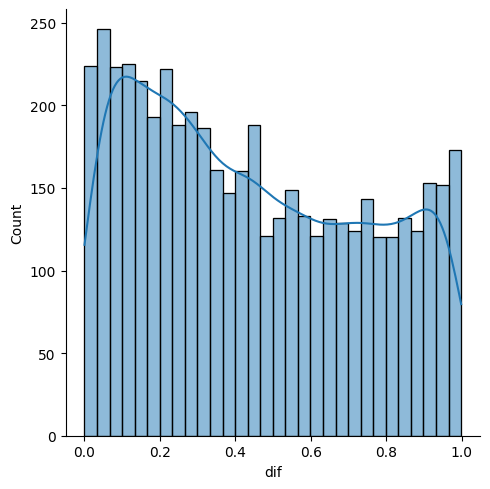

In [54]:
#Use seaborn to show histogram of dif and decide emperically a cutoff
sns.displot(df[df.prediction == 'doublet'], x= 'dif', bins=30, kde=True)

In [49]:
# Show some random samples in the doublet group to better understand the histogram
df[df.prediction =='doublet'].sample(10)

,doublet,singlet,prediction,dif
D1_analysis_TTGCATTAGGACATCG,0.557234,0.442766,doublet,0.114469
WT_CAAGACTGTTACTCAG,0.612009,0.387991,doublet,0.224018
D28_analysis_CTCTCGAAGGATAATC,0.761302,0.238698,doublet,0.522603
WT_TGCGGGTCATCAGCGC,0.615372,0.384628,doublet,0.230745
D28_analysis_GAGTTGTGTGCGAACA,0.546706,0.453294,doublet,0.093413
D7_analysis_TTGGATGGTTCTCCTG,0.803706,0.196294,doublet,0.607412
WT_AAAGGGCCAACCAGAG,0.600469,0.399531,doublet,0.200939
D28_analysis_CAAGACTAGTCCCGAC,0.966415,0.033585,doublet,0.932830
D1_analysis_AGTTAGCTCGCCTTTG,0.713393,0.286607,doublet,0.426786
D28_analysis_AGTAGTCAGCATCCTA,0.643487,0.356513,doublet,0.286973


From this probably a cut-off of dif < 0.2 seems aceptable. So everything below 0.2 could be still seen as singlet (not so high doublet score and also a quite high singlet score) and everything above definitely as doublet.

In [ ]:
# Generate a list containing only filtered doublet cells (to not loose to much data)
doublets = df[(df['prediction'] == 'doublet') & (df.dif > 0.2)]
doublets

## Doublet Removal (continue)

In [58]:
# Reload adata and annotate doublet annotation on all barcodes/cells (before we filtered out already many cells to train the model!)
adata = sc.read_text('rawdata/GSE181276_genes.counts_for_GEO_uploading.txt').T
# This annotates the cells with True/false True = doublet, false = singlet
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata.obs

,doublet
WT_AAACCCAAGCATCTTG,False
WT_AAACCCAAGGGTTGCA,False
WT_AAACCCAGTCCGAAAG,False
WT_AAACCCAGTCCGTTTC,False
WT_AAACCCAGTGTGGTCC,False
...,...
D7_analysis_TTTGTTGGTGAGCAGT,False
D7_analysis_TTTGTTGGTGCCTGAC,False
D7_analysis_TTTGTTGGTTGAGAGC,False
D7_analysis_TTTGTTGTCCTTATAC,False


In [60]:
# Filter all cells out which are not doublet (so keep all singlets)
adata = adata[~adata.obs.doublet]
adata

View of AnnData object with n_obs × n_vars = 28750 × 31053
    obs: 'doublet'

## Preprocessing 

### Filtering of Low-Quality Cells Based on Mitochondrial and Ribosomal Content

In [64]:
# Download and read ribosomal genes into python using MsigDB KEGG Ribosome Gene enrichment term.
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
# When reading the txt file we need to skip the first two rows since those contain the linke and the KEGG Pathway name. 
ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


As we can see, the ribosomal gene names in our list follow the human naming convention, where all letters are capitalized. However, our dataset is from mouse, and in mouse gene nomenclature, only the first letter is capitalized while the rest are lowercase (see code output below). Therefore, we need to adjust our ribosomal gene list accordingly by converting the gene names to the correct mouse format.

In [70]:
adata.var_names[adata.var_names.str.contains("Rps")]

Index(['Rps6kc1', 'Rps21', 'Rps4x', 'Rps6ka6', 'Rps6ka3', 'Rps3a1', 'Rps27',
       'Rps20', 'Rps6', 'Rps8', 'Rps6ka1', 'Rps9', 'Rps5', 'Rps19', 'Rps16',
       'Rps11', 'Rps17', 'Rps3', 'Rps13', 'Rps15a', 'Rps12', 'Rps15', 'Rps26',
       'Rps24', 'Rps25', 'Rps27l', 'Rps27rt', 'Rpsa', 'Rps27a', 'Rps6kb1',
       'Rps23', 'Rps7', 'Rps29', 'Rps6kl1', 'Rps6ka5', 'Rps19bp1', 'Rps6ka2',
       'Rps2', 'Rps10', 'Rps28', 'Rps18', 'Rps14', 'Rps6kb2', 'Rps6ka4',
       'Rps12-ps3'],
      dtype='object')

In [76]:
# Update Ribosome list so that only first letter is capitalized
ribo_genes[0] = ribo_genes[0].apply(lambda x: x.capitalize())
ribo_genes

,0
0,Fau
1,Mrpl13
2,Rpl10
3,Rpl10a
4,Rpl10l
...,...
83,Rps9
84,Rpsa
85,Rsl24d1
86,Rsl24d1p11


In [77]:
# Annotate which genes are ribosomal or not in adata.var
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_31182/640738055.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)


In [95]:
# Annotate which genes are mitochondrial or not in adata.var
adata.var['mt'] = adata.var.index.str.startswith('mt-')

In [99]:
# Calculate QC Metrics using scanpy function.
sc.pp.calculate_qc_metrics(adata, qc_vars=('ribo','mt'),inplace=True,log1p=False,percent_top=(50,100))

**qc_vars** are boolean columns of variables we want to control for <br>
**inplace=True** saves the metrics in adata.obs and adata.vars (n_cells/genes_by_counts are depending on adata object). <br>
**percent_top(50,100)** can be used to assess library complexity. It is the cumulative percentage of total counts per cell derived from the top50 (or top100, or top150, etc) highly expressed genes. This tells you how concentrated the reads are. If 70% of reads are accumulated in the top50 highly expressed genes the scRNA-seq library has a low complexity and the data therefore is most likely not suited for detailed anlayses.  <br>
Lets first investige library complextiy: 

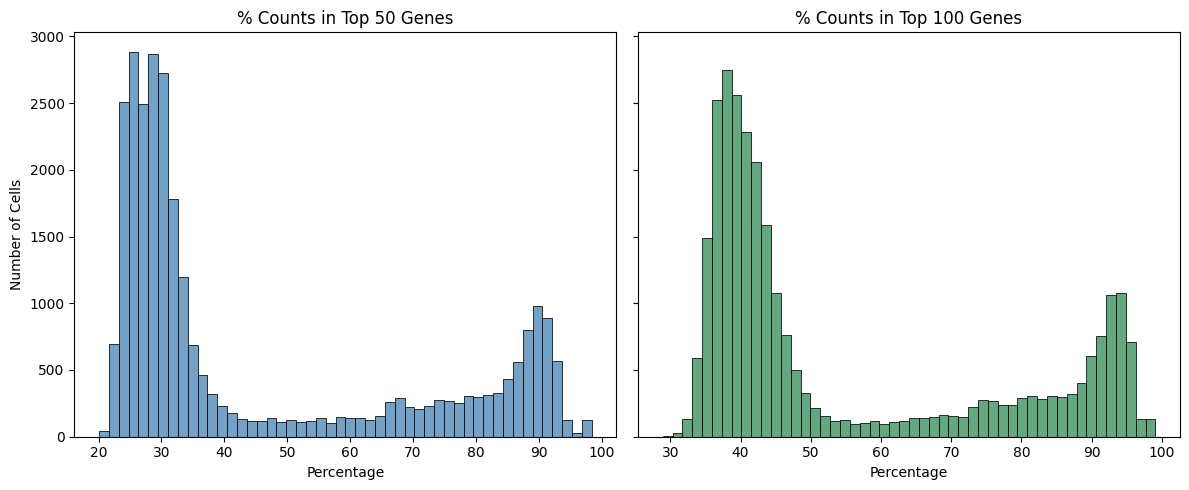

In [114]:
# Set figure size and layout
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Histogram for top 50 genes
sns.histplot(adata.obs['pct_counts_in_top_50_genes'], bins=50, ax=axes[0], color='steelblue')
axes[0].set_title('% Counts in Top 50 Genes')
axes[0].set_xlabel('Percentage')
axes[0].set_ylabel('Number of Cells')

# Histogram for top 100 genes
sns.histplot(adata.obs['pct_counts_in_top_100_genes'], bins=50, ax=axes[1], color='seagreen')
axes[1].set_title('% Counts in Top 100 Genes')
axes[1].set_xlabel('Percentage')

plt.tight_layout()
plt.show()


This plot indicates that the library complexity is generally acceptable. Most cells show an enrichment of 20–40% of total counts in the top 50 most highly expressed genes, which is considered a healthy range. However, a subset of cells displays a much higher enrichment, suggesting that a few genes dominate their expression profiles — typically a sign of lower complexity. That said, these are pancreas samples, and it's well known that certain cell types, particularly acinar cells, naturally express large amounts of digestive enzyme genes. This phenomenon is observed even in bulk RNA-seq data and reflects biological reality rather than technical artifacts. Given this context, we will not apply any additional filtering based on library complexity (e.g., removing cells with high expression of a few genes), as the observed distribution is likely driven by genuine biological features.

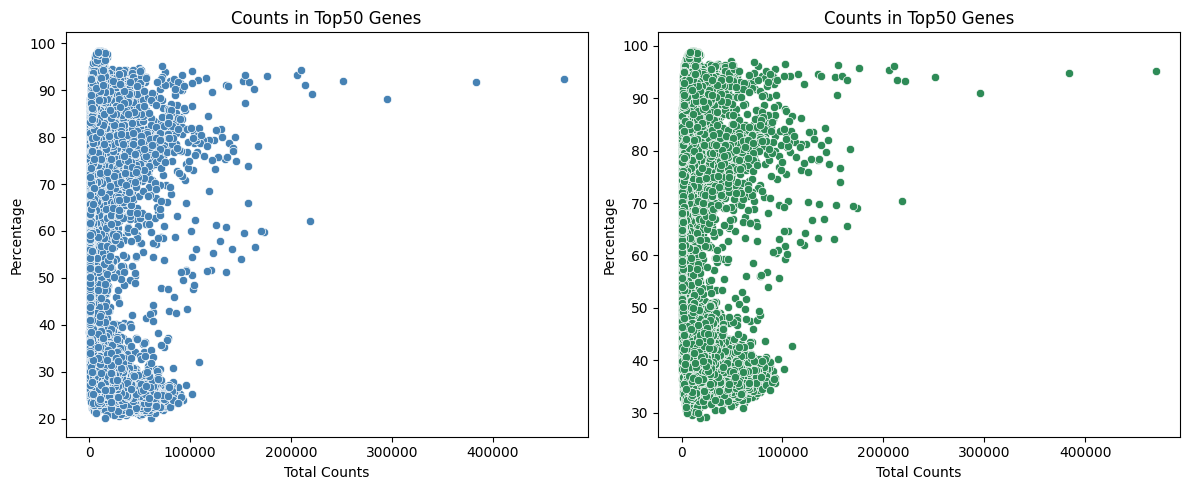

In [118]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.scatterplot(x=adata.obs['total_counts'],y=adata.obs['pct_counts_in_top_50_genes'],ax=axes[0],color ='steelblue')
axes[0].set_title('Counts in Top50 Genes')
axes[0].set_xlabel('Total Counts')
axes[0].set_ylabel('Percentage')

sns.scatterplot(x=adata.obs['total_counts'],y=adata.obs['pct_counts_in_top_100_genes'],ax=axes[1],color ='seagreen')
axes[1].set_title('Counts in Top50 Genes')
axes[1].set_xlabel('Total Counts')
axes[1].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

This plot shows us that cells where few genes account for most of the reads are not necessary cells with low reads. But many of those even have a lot of reads (which is good). For this reason that confirms that this is most likely biology and not an technical artifact (because than one would expect that those cells might have very low reads at all). 

Next we will filter the genes for expression in cells (are they expressed in any cell) and the cells for total counts if necessary (each cells requires a minimum of counts to be included in the dataset). 

In [101]:
adata.var

,ribo,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Xkr4,False,False,343,0.012730,98.806957,366.0
Gm1992,False,False,0,0.000000,100.000000,0.0
Gm37381,False,False,1,0.000035,99.996522,1.0
Rp1,False,False,8,0.000348,99.972174,10.0
Sox17,False,False,851,0.067443,97.040000,1939.0
...,...,...,...,...,...,...
AC168977.1,False,False,1,0.000035,99.996522,1.0
AC149090.1,False,False,7545,0.452800,73.756522,13018.0
CAAA01118383.1,False,False,8646,0.478261,69.926957,13750.0
Vmn2r122,False,False,0,0.000000,100.000000,0.0


Are all genes expressed or can we remove genes which are not expressed in any cell? As we see already above Gm1992 is not found in any cells. When we sort the values fo the n_cells_by_counts we will identify more genes that are not expressed. 

In [102]:
adata.var.sort_values('n_cells_by_counts')

,ribo,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
D13Ertd608e,False,False,0,0.000000,100.000000,0.0
Gm28434,False,False,0,0.000000,100.000000,0.0
Cabs1,False,False,0,0.000000,100.000000,0.0
Smr3a,False,False,0,0.000000,100.000000,0.0
Smr2,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
Ctrb1,False,False,28326,404.873009,1.474783,11640099.0
Rpl13,True,False,28378,97.232070,1.293913,2795422.0
Gm42418,False,False,28456,212.295826,1.022609,6103505.0
mt-Atp6,False,True,28476,158.565183,0.953043,4558749.0


Lets filter out all genes which are not expressed at least in 5 cells.

In [108]:
#Filter genes that they need to occur at least in 5 cells
sc.pp.filter_genes(adata,min_cells=5)

In [111]:
#Confirm shortly that filtering worked
adata.var.sort_values('n_cells_by_counts')

,ribo,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
Gpr83,False,False,5,0.000174,99.982609,5.0,5
Myo3b,False,False,5,0.000174,99.982609,5.0,5
Gm36945,False,False,5,0.000209,99.982609,6.0,5
Gm38843,False,False,5,0.000174,99.982609,5.0,5
Gm44633,False,False,5,0.000174,99.982609,5.0,5
...,...,...,...,...,...,...,...
Ctrb1,False,False,28326,404.873009,1.474783,11640099.0,28326
Rpl13,True,False,28378,97.232070,1.293913,2795422.0,28378
Gm42418,False,False,28456,212.295826,1.022609,6103505.0,28456
mt-Atp6,False,True,28476,158.565183,0.953043,4558749.0,28476


In [112]:
#Checking if we need to filter for total_counts > 200 in cells
adata.obs.sort_values('total_counts')

,doublet,n_genes_by_counts,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt
D1_analysis_TGCCGAGTCTTAGGAC,False,216,270.0,38.518519,57.037037,43.0,15.925926,14.0,5.185185
D7_analysis_TGCCGAGTCTTAGGAC,False,202,479.0,68.267223,78.705637,51.0,10.647182,11.0,2.296451
D1_analysis_CTGGTCTGTCACTTAG,False,274,493.0,52.332657,64.705882,53.0,10.750506,11.0,2.231237
D7_analysis_GTTACCCTCATGGATC,False,264,499.0,54.709419,67.134269,56.0,11.222445,31.0,6.212425
D1_analysis_ATGGTTGGTTCTCCAC,False,364,500.0,34.600000,47.200000,76.0,15.200000,30.0,6.000000
...,...,...,...,...,...,...,...,...,...
D28_analysis_TGTGTGACACGAAGAC,False,3261,221185.0,89.265095,93.262201,14141.0,6.393291,1099.0,0.496869
WT_TAATTCCCAAAGGGTC,False,3819,251561.0,91.998760,94.150524,8843.0,3.515251,790.0,0.314039
WT_AGGTCATAGACTAAGT,False,5532,295279.0,88.204038,91.085719,13214.0,4.475090,3234.0,1.095235
D28_analysis_CAGATACAGCATAGGC,False,3891,383551.0,91.803176,94.846578,18963.0,4.944062,811.0,0.211445


The authors of the paper did apparently filter for all cells that contain more than 200 total counts. For this reason we can continue without filtering. Ohterwise we would use this function of scanpy (the 200 is a good rule of thumb but arbitrary and might change based on data): <br>

    sc.pp.filter_cells(adata, min_genes=200) 

In [ ]:
# To check the Quality control batchwise we assign a new column with the batch name extracted from the cell barcode.
adata.obs['batch'] = adata.obs.index.str.split('_').str[0]

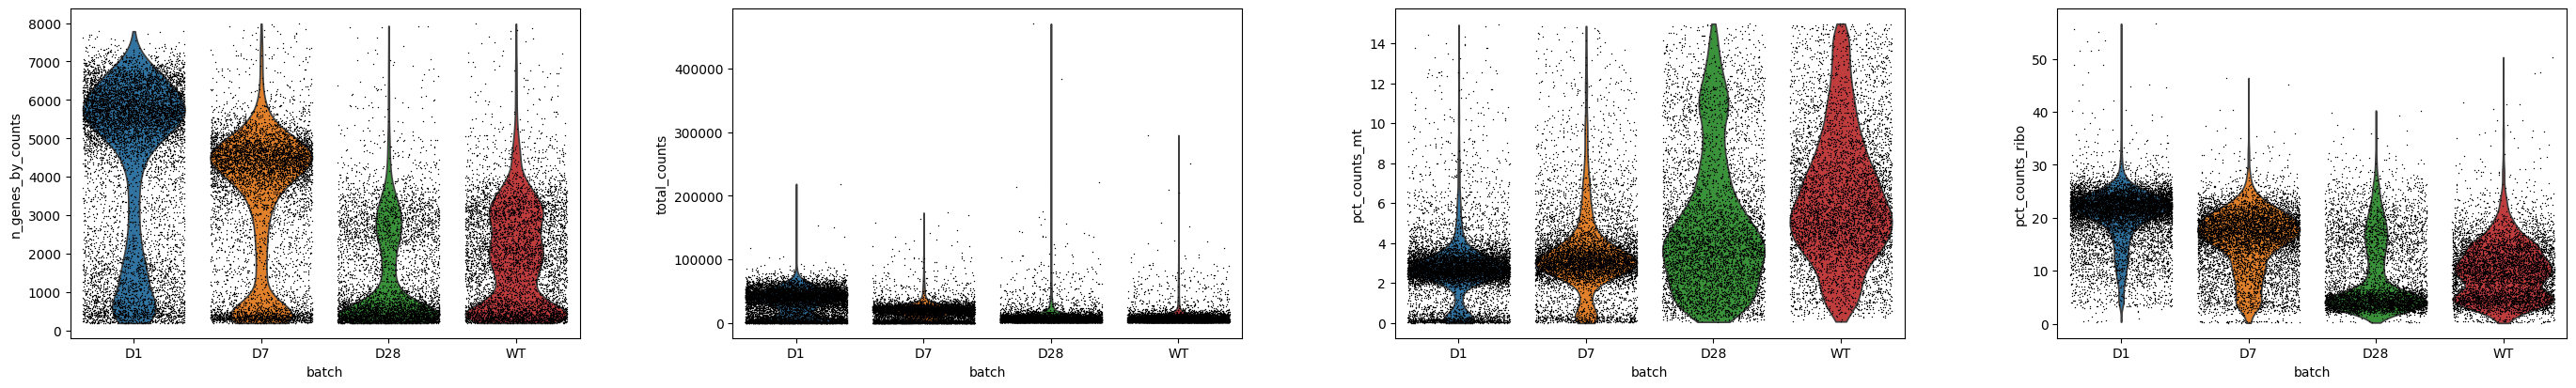

In [127]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], groupby='batch',
             jitter = 0.4, multi_panel = True)

The quality control should be run "batch" specific since those can differ dramatically as we see here. Some observations we make here: <br>

1.) In general we can observe that D1 and D7 samples are much better quality than D28 and WT samples. D28 and WT samples have lower n_genes_by_counts values, some cells have exteremyl high total counts (especialy D28).

2.) D28 and WT cells contain more cells with higher mitochondrial RNA content, however most of them are not higher than 15%. This might still be fine. We will probably first apply loose filtering setting and will come back if the data is not interpretable to this step. Then we still can apply stricter filterings.

3.) The D1 and D7 samples have higher ribosomal RNA content. This is explainable most likely by biology since during pancreatitis a lot of cells die. But also D28 and WT cells contains cells with high ribosomal values, indicating that the isolation method for the cells probably was a little harsh. 

In [128]:
#First we filter for n_genes_by_counts and remove cells with really high genes numbers for counts (multiplets,still potential doublets). 
# To be objective we determine and will use the 98 percentile of the n_genes_by_counts
upper_lims = adata.obs.groupby('batch')['n_genes_by_counts'].quantile(0.98)
upper_lims

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_31182/2172312677.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  upper_lims = adata.obs.groupby('batch')['n_genes_by_counts'].quantile(0.98)


batch
D1     6999.00
D7     5994.16
D28    4648.56
WT     4945.24
Name: n_genes_by_counts, dtype: float64

In [131]:
# We filter out cells above the 98 percentile of each batch
adata = adata[~adata.obs.apply(lambda row: row['n_genes_by_counts'] > upper_lims[row['batch']],axis=1)]

In [132]:
adata

View of AnnData object with n_obs × n_vars = 28174 × 17902
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_colors'

We filtered out a few cells (coming from 28750 after doublet removal) we loose again 576 cells. This is absolutely acceptable. Let's next filter for mitochondrial and ribosomal gene counts. 

In [134]:
# As mentioned we will not be very strtic here first. 
#Therfore we next filter the mitochondria on 20% (we will not loose anything as they are all below 15%)
adata = adata[adata.obs.pct_counts_mt < 20]

I did not mention above that acinar cells might have higher ribo counts since they synthesize a lot of protein (more ribosomes). For this reason the increase in ribosomal RNA is also biological function especially in D28 and WT. We assume therefore for now, that everything until 25% is completely fine. Probably for Day28 for instance and WT we could go lower to 20%. However, if the data later on shows to be not good or not interpretable we could still lower this value. 

In [138]:
# Filter for alls cells below 25% ribo counts
adata = adata[adata.obs.pct_counts_ribo < 25]

In [139]:
adata

View of AnnData object with n_obs × n_vars = 26752 × 17902
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_colors'

# Normalization